In [2]:
from datasets import load_dataset, Image, Dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Image Cleanup

In [3]:
labels = pd.read_csv("/kaggle/input/spr-x-ray-age/train_age.csv").sort_values("imageId")["age"].tolist()
train_path = "/kaggle/input/spr-x-ray-age/kaggle/kaggle/train/"
train_files = sorted(os.listdir(train_path))  
ds = Dataset.from_dict({"image": [f"{train_path}{f}" for f in train_files],
                            "label": labels}).cast_column("image", Image())
ds = ds.train_test_split(test_size=0.2)

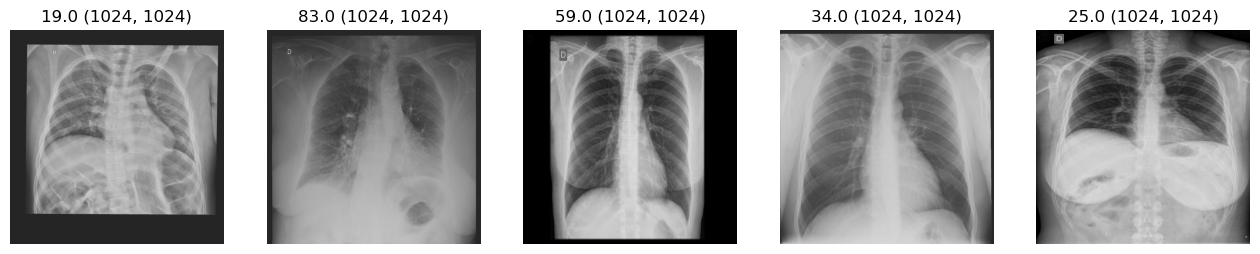

In [4]:
def preview_data(n):
    image_list = ds["train"][:n]["image"]
    labels = ds["train"][:n]["label"]
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(16, 10))
    for i, image in enumerate(image_list):
        axes[i].imshow(image)
        axes[i].set_title(f"{labels[i]} {image.size}")
        axes[i].axis("off")
plt.show()

preview_data(5)

In [5]:
def crop_border(img):
    gs = np.array(img)[..., :3] @ [0.299, 0.587, 0.114]
    rows_to_remove = np.where((gs <= 100).sum(axis=1) == gs.shape[1])[0]
    cols_to_remove = np.where((gs <= 100).sum(axis=0) == gs.shape[0])[0]
    gs = np.delete(gs, rows_to_remove, axis=0)
    gs = np.delete(gs, cols_to_remove, axis=1)
    return PILImage.fromarray(np.uint8(gs) , "L")


def transforms(examples):
    examples["image"] = [crop_border(image).convert("RGB").resize((224,224)) for image in examples["image"]]
    return examples

In [ ]:
ds = ds.map(transforms, batched=True)
preview_data(5)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

# Fine-Tune ViT from 🤗

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
train_inputs = processor(images=ds["train"]["image"], return_tensors="pt")["pixel_values"]
val_inputs = processor(images=ds["test"]["image"], return_tensors="pt")["pixel_values"]
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k").to(device)

class NumericOutputLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x
    

# Modify the output layer to output a single scalar value
input_dim = model.classifier.in_features
output_dim = 1  # Set the output dimension to 1 for numeric prediction
model.classifier = NumericOutputLayer(input_dim, output_dim).to(device)



train_dataset = TensorDataset(train_inputs, torch.FloatTensor(ds["train"]["label"]))
val_dataset = TensorDataset(val_inputs, torch.FloatTensor(ds["test"]["label"]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)


optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.L1Loss().to(device)  # MAE
num_epochs = 30
val_losses = [0]*num_epochs
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch.to(device))
        loss = loss_fn(torch.flatten(outputs.logits), y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch.to(device))
            loss = loss_fn(torch.flatten(outputs.logits), y_batch.to(device))
            val_loss += loss.item() * len(x_batch)
        val_loss /= len(val_dataset)
        val_losses[epoch] = val_loss
        print("Epoch {}, Validation Loss: {:.4f}".format(epoch+1, val_loss))

In [ ]:
plt.plot(val_losses, "-o")
plt.ylabel("Validation MAE")
plt.xlabel("Epoch");

# Inference

In [ ]:
test_path = "/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/"
test_files = os.listdir(test_path)

ds_test = Dataset.from_dict({"image": [f"{test_path}{f}" for f in test_files],
                            "imageId": [int(x.split(".")[0]) for x in test_files]}).cast_column("image", Image())
ds_test = ds_test.map(transforms, batched=True, batch_size=100)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
test_inputs = processor(images=ds_test["image"], return_tensors="pt")["pixel_values"]

In [ ]:
outputs = model(test_inputs)
preds = outputs.logits

In [ ]:
batch_size = 32
preds = []
for i in range(0, len(test_inputs), batch_size):
    preds += torch.flatten(model(test_inputs[i:i+batch_size]).logits).tolist()

In [ ]:
pd.DataFrame({"imageId": ds_test["imageId"],
             "age": [p if p > 0 else 0 for p in preds]}).to_csv("submission.csv", index=False)